In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import jit
import jax
from jax.lib import xla_bridge

In [2]:
print(xla_bridge.get_backend().platform)

cpu


### Grid 

In [3]:
class Grid:
    def __init__(self, xmin: float, xmax: float, nx: int, n_ghost: int = 1):
        self.xmin = xmin
        self.xmax = xmax
        self.nx = nx
        self.tot_nx = nx + 2 * n_ghost
        self.dx = (xmax - xmin) / (nx - 1)
        self.x = jnp.linspace(xmin, xmax, nx)
        self.x = jnp.insert(self.x, 0, self.x[0])
        self.x = jnp.insert(self.x, self.x.shape[0], self.x[-1])

### Primitive variables to conserved variables

In [4]:
@jit
def prim_to_cons_vars(pv: jnp.ndarray) -> jnp.ndarray:
    cv = jnp.zeros(pv.shape)
    cv = cv.at[:,0].set(pv[:, 0])
    cv = cv.at[:,1].set(pv[:, 0] * pv[:, 1])
    cv = cv.at[:,2].set(pv[:, 0] * (pv[:, 2] / (pv[:, 0] * (1.4 - 1)) + 0.5 * pv[:, 1] ** 2))

    return cv

### Conserved variables to primitive variables

In [5]:
@jit
def cons_to_prim_vars(cv: jnp.ndarray) -> jnp.ndarray:
    pv = jnp.zeros(cv.shape)
    pv = pv.at[:, 0].set(cv[:, 0])
    pv = pv.at[:, 1].set(cv[:, 1] / cv[:, 0])
    pv = pv.at[:, 2].set((cv[:, 2] / cv[:, 0] - 0.5 * pv[:, 1] ** 2) * cv[:, 0] * (1.4 - 1))

    return pv

### Conserved variables to flux

In [6]:
@jit
def conv_vars_to_flux(cv: jnp.ndarray) -> jnp.ndarray:
    pv = cons_to_prim_vars(cv)
    f = jnp.zeros(cv.shape)
    f = f.at[:, 0].set(cv[:, 1])
    f = f.at[:, 1].set(pv[:, 2] + cv[:, 1] * pv[:, 1])
    f = f.at[:, 2].set(pv[:, 2] * pv[:, 1] + cv[:, 2] * pv[:, 1])

    return f

### To compute time step

In [7]:
@jit
def time_step(cv: jnp.ndarray, dx: float, cfl: float = 0.2) -> jnp.ndarray:
    pv = cons_to_prim_vars(cv)
    a = jnp.sqrt(1.4 * pv[:, 2] / pv[:, 0])
    eig_val = jnp.abs(pv[:, 1] + a)
    dt = cfl * dx / eig_val
    
    return jnp.min(dt)

### To compute Rusanov (LLF) flux

In [8]:
@jit
def llf_flux(cv: jnp.ndarray) -> jnp.ndarray:
    f = conv_vars_to_flux(cv)
    pv = cons_to_prim_vars(cv)
    a = jnp.sqrt(1.4 * pv[:, 2] / pv[:, 0])
    eig_val_l = jnp.abs(pv[1:-1, 1]) + a[1:-1]
    eig_val_r = jnp.abs(pv[2:, 1]) + a[2:]
    max_eig_val = jnp.maximum(eig_val_l, eig_val_r)
    max_eig_val = max_eig_val.reshape(max_eig_val.size, 1)
    f_iph = 0.5 * (f[1:-1, :] + f[2:, :]) - 0.5 * max_eig_val * (cv[2:, :] - cv[1:-1, :])

    eig_val_l = jnp.abs(pv[:-2, 1]) + a[:-2]
    eig_val_r = jnp.abs(pv[1:-1, 1]) + a[1:-1]
    max_eig_val = jnp.maximum(eig_val_l, eig_val_r)
    max_eig_val = max_eig_val.reshape(max_eig_val.size, 1)
    f_imh = 0.5 * (f[1:-1, :] + f[:-2, :]) - 0.5 * max_eig_val * (cv[1:-1, :] - cv[:-2, :])

    return f_iph - f_imh

### Initial conditions

In [9]:
def initialize(pv_l: jnp.ndarray, pv_r: jnp.ndarray, x: jnp.ndarray, pv: jnp.ndarray, xloc):
    pv=pv.at[jnp.argwhere(x <= xloc), :].set(pv_l)
    pv=pv.at[jnp.argwhere(x > xloc), :].set(pv_r)
    
    return pv

### Boundary conditions

In [10]:
@jit
def bc(cv: jnp.ndarray) -> jnp.ndarray:
    pv = cons_to_prim_vars(cv)
    pv = jnp.insert(pv, 0, pv[0], axis=0)
    pv = jnp.insert(pv, pv.shape[0], pv[-1], axis=0)
    con_var = prim_to_cons_vars(pv)

    return con_var

### Simulation parameters

In [11]:
prim_var_l = jnp.array([1.0, 0.75, 1.0])
prim_var_r = jnp.array([0.125, 0.0, 0.1])

cfl_num = 0.9
grid = Grid(0, 1, 1001)
x_grid = grid.x
x_loc = 0.3
prim_var = jnp.zeros((x_grid.size, 3))
prim_var = initialize(prim_var_l, prim_var_r, x_grid, prim_var, x_loc)
# print(prim_var)
cons_var = prim_to_cons_vars(prim_var)
# print(cons_var)
flux = conv_vars_to_flux(cons_var)
prim_var = cons_to_prim_vars(cons_var)

### Run the simulation

In [12]:
%%time
time = 0
while time <= 0.2:
    t_dt = time_step(cons_var, grid.dx, cfl_num)
    flux = llf_flux(cons_var)
    cv_new = cons_var[1:-1, :] - (t_dt / grid.dx) * flux
    cons_var = bc(cv_new)
    time += t_dt
    print(time)

0.0004655455
0.00088304735
0.0012766281
0.001655027
0.0020256073
0.0023936369
0.0027578631
0.0031157434
0.0034709622
0.0038232978
0.0041723833
0.0045201397
0.004867265
0.005211972
0.005555554
0.005898653
0.006239865
0.006580139
0.00692052
0.0072592623
0.0075971293
0.007935035
0.008271811
0.008607763
0.008943652
0.009278902
0.009613367
0.009947683
0.010281693
0.01061497
0.010948034
0.011281036
0.011613363
0.011945435
0.012277599
0.012609157
0.012940436
0.013271902
0.013602829
0.013933472
0.014264209
0.014594615
0.014924748
0.015254904
0.015584874
0.015914591
0.016244283
0.016573887
0.016903263
0.017232586
0.01756188
0.017890973
0.018219998
0.01854903
0.018877884
0.019206667
0.019535476
0.01986413
0.020192716
0.020521339
0.020849824
0.021178244
0.021506699
0.02183504
0.022163322
0.022491625
0.022819845
0.023148011
0.023476189
0.023804309
0.024132378
0.024460452
0.02478849
0.025116477
0.025444465
0.025772434
0.026100352
0.026428267
0.026756182
0.027084045
0.0274119
0.027739769
0.028067587

### Plot results

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

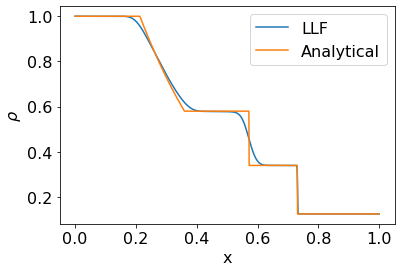

In [13]:
prim_var = cons_to_prim_vars(cons_var)
analytical = np.loadtxt('/mnt/external_data/maruthi/my_codes/compressible_euler_1d/output/shock_tube.dat')
plt.plot(x_grid, prim_var[:, 0], label='LLF')
plt.plot(analytical[:, 0], analytical[:, 1], label='Analytical')
plt.xlabel('x', fontsize=16)
plt.ylabel(r'$\rho $', fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)